In [9]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


## Necessary classes and functions

In [10]:
# list cuda devices
print("Available CUDA devices:")
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Available CUDA devices:
Device 0: NVIDIA RTX A6000
Device 1: NVIDIA RTX A6000


In [11]:
# calculate module parameter count
def model_param_count(mdl):
    return sum(p.numel() for p in mdl.parameters() if p.requires_grad)

In [12]:
class MC_RNN_Dataset(Dataset):
    def __init__(self, data, labels, frame_num=32, chan_num=2, use_sector=False, num_sectors=9):
        """
        Args:
            data (np.ndarray): Array of shape (num_samples, num_frames, height, width)
            labels (np.ndarray): DataFrame with columns ['fg_char_id', 'fg_char_x', 'fg_char_y']
            frame_num (int): Number of frames to stack for input as multichannel image
            chan_num (int): Number of channels in the input images. Each channel is a previous frame.
            use_sector (bool): 如果为 True，则把 (x, y) 位置映射为 0-(num_sectors-1) 的 sector id
            num_sectors (int): sector 的数量，例如 9 表示 0-8 共 9 个 sector
        """
        self.data = data
        self.labels = labels[['fg_char_id', 'fg_char_x', 'fg_char_y']].values
        self.frame_num = frame_num
        self.chan_num = chan_num
        self.use_sector = use_sector
        self.num_sectors = num_sectors

    def __len__(self):
        return (self.data.shape[0]-self.chan_num) // self.frame_num

    def __getitem__(self, idx):
        start_idx = (idx * self.frame_num) + self.chan_num
        end_idx = start_idx + self.frame_num

        # Stack frames to create a multichannel image
        for i in range(-(self.chan_num-1), 1):
            if i == -(self.chan_num-1):
                stacked_frames = np.expand_dims(self.data[(start_idx + i):(end_idx + i)], axis=1)
            else:
                stacked_frames = np.concatenate((stacked_frames,
                                                 np.expand_dims(self.data[(start_idx + i):(end_idx + i)],
                                                                axis=1)), axis=1)
        stacked_frames = stacked_frames.astype(np.float32)

        # labels: (frame_num, 3) -> [char_id, x, y]
        labels = self.labels[start_idx:end_idx].copy()

        if self.use_sector:
            # 使用图像宽度和高度，把 (x, y) 映射到一个 grid_size x grid_size 的网格上，
            # 得到 0-(num_sectors-1) 的 sector id（例如 num_sectors=9 -> 3x3 grid）
            height = self.data.shape[-2]
            width = self.data.shape[-1]

            # 根据 num_sectors 推出每一维的 grid_size（假设 num_sectors 是完全平方数，如 9, 16 等）
            grid_size = int(np.sqrt(self.num_sectors))
            if grid_size * grid_size != self.num_sectors:
                raise ValueError(f"num_sectors={self.num_sectors} 不是完全平方数，无法构成 grid_size x grid_size 网格")

            x = labels[:, 1].astype(np.float32)
            y = labels[:, 2].astype(np.float32)

            # 将坐标归一化到 [0, grid_size) 再取整，注意用 (width-1)/(height-1) 避免越界
            col = (x / max(width - 1, 1) * grid_size).astype(np.int64)
            row = (y / max(height - 1, 1) * grid_size).astype(np.int64)

            # 防止因为数值或边界问题越界
            col = np.clip(col, 0, grid_size - 1)
            row = np.clip(row, 0, grid_size - 1)

            # 按行优先编码 sector id: row * grid_size + col，范围 0-(num_sectors-1)
            sector = row * grid_size + col

            # 新的 label: [char_id, sector_id]
            labels = np.stack([labels[:, 0].astype(np.int64), sector], axis=1)

        return stacked_frames, labels

In [13]:
class RNNConv(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        # 原始 RNN 版本
        self.rnn = nn.RNN(input_size=64 * 12 * 12, hidden_size=256,
                          num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(256)
        self.fcchar = nn.Linear(256, num_classes)
        self.fcpos = nn.Linear(256, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnn(x)[0]
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out


class GRUConv(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(GRUConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnn = nn.GRU(input_size=64 * 12 * 12, hidden_size=256,
                          num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(256)
        self.fcchar = nn.Linear(256, num_classes)
        self.fcpos = nn.Linear(256, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnn(x)[0]
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)

        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out


class LSTMConv(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(LSTMConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnn = nn.LSTM(input_size=64 * 12 * 12, hidden_size=256,
                           num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(256)
        self.fcchar = nn.Linear(256, num_classes)
        self.fcpos = nn.Linear(256, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnn(x)[0]
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)

        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out



In [ ]:
# 封装的可视化函数和保存/加载功能
def visualize_results(results, model, test_ds, test_dl, use_sector=False, num_sectors=10, num_vis=8):
    """
    可视化训练结果和测试集预测
    
    Args:
        results: 训练结果字典，包含 'train_acc_char', 'val_acc_char' 等（不包含 'model'）
        model: 训练好的模型对象（单独传递）
        test_ds: 测试数据集
        test_dl: 测试数据加载器
        use_sector: 如果为 True，则可视化 sector location；否则可视化坐标
        num_sectors: sector 数量（仅在 use_sector=True 时使用）
        num_vis: 可视化的样本数量
    """
    # 1. 绘制训练 / 验证性能曲线
    plt.figure(figsize=(12, 5))
    
    # 字符识别准确率
    plt.subplot(1, 2, 1)
    plt.plot(results["train_acc_char"], label="train char acc")
    plt.plot(results["val_acc_char"], label="val char acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Character accuracy")
    plt.legend()
    
    # 位置相关指标
    plt.subplot(1, 2, 2)
    if use_sector:
        # sector 模式：显示准确率
        if "train_acc_pos" in results and "val_acc_pos" in results:
            plt.plot(results["train_acc_pos"], label="train sector acc")
            plt.plot(results["val_acc_pos"], label="val sector acc")
            plt.ylabel("Accuracy (%)")
            plt.title("Sector accuracy")
        else:
            print("Warning: train_acc_pos or val_acc_pos not found in results")
    else:
        # 坐标模式：显示 MSE
        if "train_err_pos" in results and "val_err_pos" in results:
            plt.plot(results["train_err_pos"], label="train pos MSE")
            plt.plot(results["val_err_pos"], label="val pos MSE")
            plt.ylabel("MSE (pixel^2)")
            plt.title("Position error")
        else:
            print("Warning: train_err_pos or val_err_pos not found in results")
    plt.xlabel("Epoch")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 2. 使用训练好的模型在 test set 上推理
    mdl_eval = model
    # 检测设备：如果 CUDA 可用，使用 CUDA；否则使用 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mdl_eval = mdl_eval.to(device)
    mdl_eval.device = device.type  # 设置模型内部的 device 属性
    mdl_eval.eval()
    
    all_char_pred = []
    all_char_gt = []
    all_pos_pred = []
    all_pos_gt = []
    
    with torch.no_grad():
        for batch in test_dl:
            inputs, labels = batch
            # 确保输入数据在正确的设备上
            inputs = inputs.to(device)
            labels = labels.to(device)
            out_char, out_pos = mdl_eval(inputs)
            
            # 取每个序列最后一帧的预测
            pred_char = torch.argmax(out_char[:, -1, :], dim=-1).cpu().numpy()
            gt_char = labels[:, -1, 0].long().cpu().numpy()
            
            if use_sector:
                # sector 模式：预测和 GT 都是 sector id
                pred_pos = torch.argmax(out_pos[:, -1, :], dim=-1).cpu().numpy()
                gt_pos = labels[:, -1, 1].long().cpu().numpy()
            else:
                # 坐标模式：预测和 GT 都是 (x, y) 坐标
                pred_pos = out_pos[:, -1, :].cpu().numpy()
                gt_pos = labels[:, -1, 1:].float().cpu().numpy()
            
            all_char_pred.append(pred_char)
            all_char_gt.append(gt_char)
            all_pos_pred.append(pred_pos)
            all_pos_gt.append(gt_pos)
    
    # 拼接为 numpy 数组
    all_char_pred = np.concatenate(all_char_pred, axis=0)
    all_char_gt = np.concatenate(all_char_gt, axis=0)
    all_pos_pred = np.concatenate(all_pos_pred, axis=0)
    all_pos_gt = np.concatenate(all_pos_gt, axis=0)
    
    # 计算 test 上整体性能
    char_acc_test = (all_char_pred == all_char_gt).mean() * 100.0
    if use_sector:
        pos_acc_test = (all_pos_pred == all_pos_gt).mean() * 100.0
        print(f"Test character accuracy: {char_acc_test:.2f}%")
        print(f"Test sector accuracy: {pos_acc_test:.2f}%")
    else:
        pos_mse_test = ((all_pos_pred - all_pos_gt) ** 2).mean()
        print(f"Test character accuracy: {char_acc_test:.2f}%")
        print(f"Test position MSE: {pos_mse_test:.2f} pixel^2")
    
    # 3. 可视化若干 test 样本
    fig, axes = plt.subplots(2, num_vis // 2, figsize=(3 * (num_vis // 2), 6))
    axes = axes.flatten()
    
    # 获取图像宽度（用于 sector 可视化）
    img_width = test_ds.data.shape[-1] if hasattr(test_ds, 'data') else 96
    img_height = test_ds.data.shape[-2] if hasattr(test_ds, 'data') else 96

    # 根据 num_sectors 计算 grid_size（例如 num_sectors=9 -> grid_size=3）
    # 兼容完全平方数（如 9, 16）和非完全平方数（如 10，旧 1D sector 模型）
    is_perfect_square = False
    grid_size = None
    if use_sector:
        grid_size = int(np.sqrt(num_sectors))
        is_perfect_square = (grid_size * grid_size == num_sectors)
        if not is_perfect_square:
            # 对于非完全平方数（如 num_sectors=10），使用 1D 排列
            # 将 10 个 sector 排列成一行（或一列）
            print(f"警告：num_sectors={num_sectors} 不是完全平方数，使用 1D 排列进行可视化")
            grid_size = num_sectors  # 对于 1D，grid_size = num_sectors（一行）
    
    for i in range(num_vis):
        img_seq, label_seq = test_ds[i]
        last_frame = img_seq[-1, 0]
        
        ax = axes[i]
        ax.imshow(last_frame, cmap="gray")
        
        # 添加网格线（仅当是完全平方数时）
        if use_sector and is_perfect_square:
            # 添加 grid_size x grid_size 白色网格线，便于判断 sector location
            # 绘制 (grid_size-1) 条垂直线（将图像分成 grid_size 列）
            for j in range(1, grid_size):
                x_pos = j * img_width / grid_size
                ax.axvline(x=x_pos, color='white', linewidth=1.5, alpha=0.8)
            # 绘制 (grid_size-1) 条水平线（将图像分成 grid_size 行）
            for j in range(1, grid_size):
                y_pos = j * img_height / grid_size
                ax.axhline(y=y_pos, color='white', linewidth=1.5, alpha=0.8)
        
        # GT
        gt_c = int(all_char_gt[i])
        if use_sector:
            # sector 模式：显示 sector id
            gt_sector = int(all_pos_gt[i])

            if is_perfect_square:
                # 完全平方数：将 sector id 解码为 (row, col)
                gt_row = gt_sector // grid_size
                gt_col = gt_sector % grid_size
                # 计算 sector 中心坐标
                gt_x = (gt_col + 0.5) * (img_width / grid_size)
                gt_y = (gt_row + 0.5) * (img_height / grid_size)
            else:
                # 非完全平方数（1D）：将 sector id 映射到图像上
                # 对于 num_sectors=10，将 10 个 sector 均匀分布在图像宽度上
                gt_x = (gt_sector + 0.5) * (img_width / num_sectors)
                gt_y = img_height / 2  # 放在图像中间

            ax.scatter([gt_x], [gt_y], c="lime", s=40, label="GT" if i == 0 else "")
            ax.text(gt_x + 1, gt_y + 1, f"C{gt_c}/S{gt_sector}", color="lime", fontsize=8)
            
            # Pred
            pd_c = int(all_char_pred[i])
            pd_sector = int(all_pos_pred[i])
            
            if is_perfect_square:
                # 完全平方数：将 sector id 解码为 (row, col)
                pd_row = pd_sector // grid_size
                pd_col = pd_sector % grid_size
                # 计算 sector 中心坐标
                pd_x = (pd_col + 0.5) * (img_width / grid_size)
                pd_y = (pd_row + 0.5) * (img_height / grid_size)
            else:
                # 非完全平方数（1D）：将 sector id 映射到图像上
                pd_x = (pd_sector + 0.5) * (img_width / num_sectors)
                pd_y = img_height / 2  # 放在图像中间

            ax.scatter([pd_x], [pd_y], c="red", s=40, marker="x", label="Pred" if i == 0 else "")
            ax.text(pd_x + 1, pd_y + 1, f"C{pd_c}/S{pd_sector}", color="red", fontsize=8)
        else:
            # 坐标模式：显示 (x, y) 坐标
            gt_x, gt_y = all_pos_gt[i]
            ax.scatter([gt_x], [gt_y], c="lime", s=40, label="GT" if i == 0 else "")
            ax.text(gt_x + 1, gt_y + 1, str(gt_c), color="lime", fontsize=10)
            
            # Pred
            pd_c = int(all_char_pred[i])
            pd_x, pd_y = all_pos_pred[i]
            ax.scatter([pd_x], [pd_y], c="red", s=40, marker="x", label="Pred" if i == 0 else "")
            ax.text(pd_x + 1, pd_y + 1, str(pd_c), color="red", fontsize=10)
        
        ax.set_axis_off()
    
    # 统一 legend
    handles, labels_legend = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels_legend, loc="upper right")
    
    plt.tight_layout()
    plt.show()


def load_results(filepath, model_class=None, model_kwargs=None):
    """
    从本地文件加载训练结果
    
    Args:
        filepath: 结果文件路径
        model_class: 模型类（例如 RNNConv），如果需要加载模型
        model_kwargs: 模型初始化参数（字典）
    
    Returns:
        结果字典（如果提供了 model_class，则包含 'model'）
    """
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    
    # 如果提供了 model_class，尝试加载模型
    if model_class is not None and "model_path" in results:
        model_path = results["model_path"]
        if os.path.exists(model_path):
            if model_kwargs is None:
                model_kwargs = {}
            model = model_class(**model_kwargs)
            model.load_state_dict(torch.load(model_path, map_location='cpu'))
            model.eval()
            results["model"] = model
            print(f"Model loaded from: {model_path}")
        else:
            print(f"Warning: Model file not found at {model_path}")
    
    print(f"Results loaded from: {filepath}")
    return results

## Recurrent network simulation

In [15]:
# 加载 test 数据集并构建 DataLoader（sector 模式）
stim_test_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-test.npy"
label_test_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-test.tsv"
stims_test = np.load(stim_test_path, allow_pickle=True)
lbls_test = pd.read_csv(label_test_path, sep="\t", index_col=0)

test_ds_sector = MC_RNN_Dataset(stims_test, lbls_test, use_sector=True)
test_dl_sector = DataLoader(test_ds_sector, batch_size=8, shuffle=False)

Results loaded from: /G/MIMOlab/Codes/aim3_RNN/results_rnn_sector.pkl
检测到 checkpoint 中的 num_pos = 9
模型加载成功，num_pos = 9


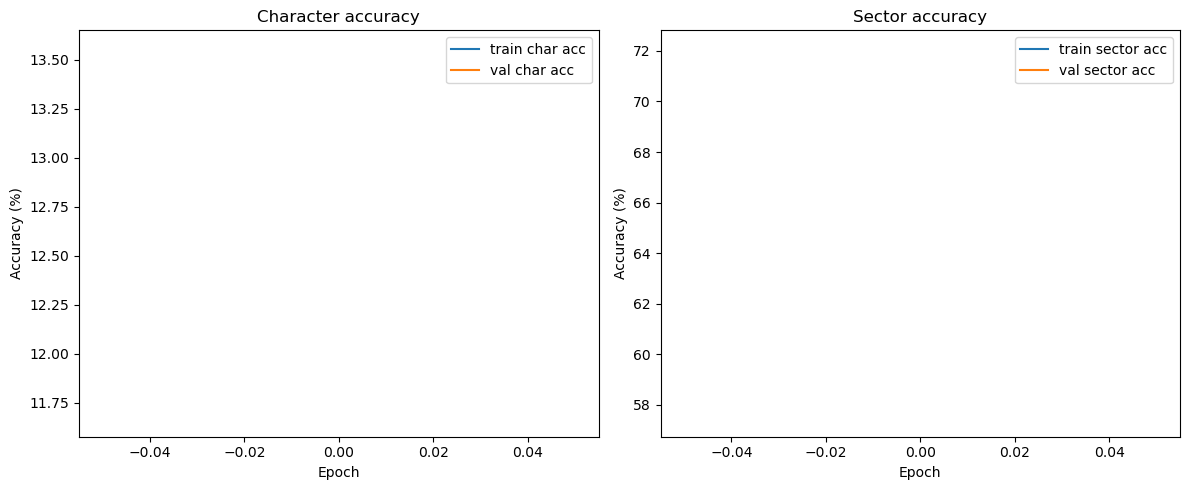

Test character accuracy: 15.56%
Test sector accuracy: 72.32%


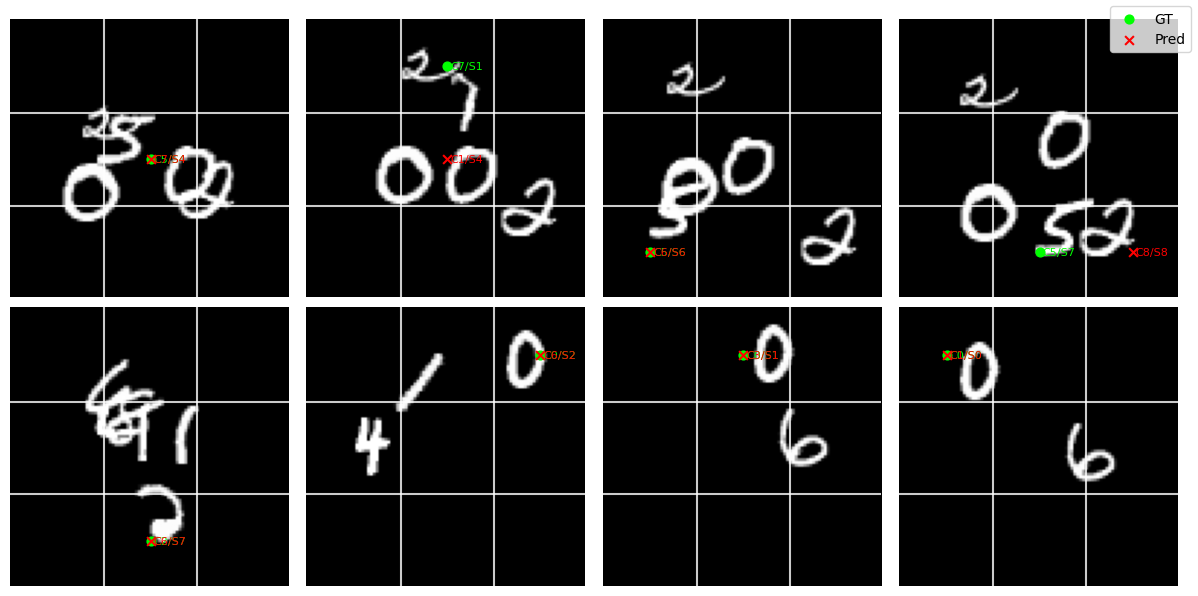

Loaded results keys: ['train_acc_char', 'val_acc_char', 'train_acc_pos', 'val_acc_pos']
Final train char acc: 11.67%
Final val char acc: 13.56%


In [22]:
# 从本地加载保存的训练结果（示例：重启 kernel 后使用）

# 加载 sector 训练结果（不包含模型）
# 注意：如果 notebook 在 notebooks/ 目录下运行
results_rnn_sector = load_results("/G/MIMOlab/Codes/aim3_RNN/results_rnn_sector.pkl")

# 如果保存的是整个模型，直接加载；如果是 state_dict，需要先创建模型实例
loaded_data = torch.load("/G/MIMOlab/Codes/aim3_RNN/results_rnn_sector_model.pth", map_location='cpu')

if isinstance(loaded_data, dict):
    # 加载的是 state_dict，需要创建模型实例
    # 自动检测 checkpoint 中的 num_pos（从 fcpos.weight 的形状推断）
    if 'fcpos.weight' in loaded_data:
        detected_num_pos = loaded_data['fcpos.weight'].shape[0]
        print(f"检测到 checkpoint 中的 num_pos = {detected_num_pos}")
    else:
        # 如果找不到 fcpos.weight，默认使用 9（新的 3x3 grid）
        detected_num_pos = 9
        print(f"警告：无法从 checkpoint 检测 num_pos，使用默认值 {detected_num_pos}")
    
    model_rnn_sector = RNNConv(num_classes=10, num_pos=detected_num_pos, kernel_size=5, device='cpu')
    model_rnn_sector.load_state_dict(loaded_data)
    print(f"模型加载成功，num_pos = {detected_num_pos}")
else:
    # 加载的是整个模型对象
    model_rnn_sector = loaded_data
    # 从模型对象中获取 num_pos
    detected_num_pos = model_rnn_sector.fcpos.out_features
    print(f"从模型对象加载，num_pos = {detected_num_pos}")

model_rnn_sector.eval()

# 将 results 和 model 一起传递给 visualize_results
# 使用检测到的 num_pos 作为 num_sectors（兼容旧模型 num_pos=10 和新模型 num_pos=9）
visualize_results(results_rnn_sector, model_rnn_sector, test_ds_sector, test_dl_sector, use_sector=True, num_sectors=detected_num_pos, num_vis=8)


# 查看加载的结果
print("Loaded results keys:", list(results_rnn_sector.keys()))
if "train_acc_char" in results_rnn_sector:
    print(f"Final train char acc: {results_rnn_sector['train_acc_char'][-1]:.2f}%")
    print(f"Final val char acc: {results_rnn_sector['val_acc_char'][-1]:.2f}%")

### Weight matrix analysis

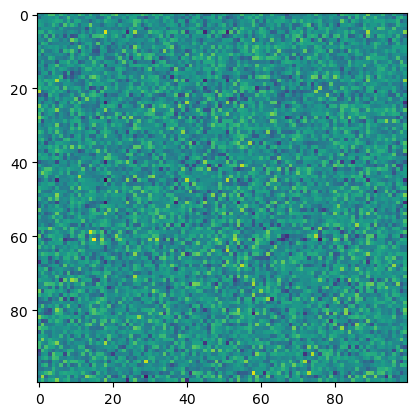

In [ ]:
params = list(mdl_rnn.rnn.parameters())[1].cpu().detach().numpy()
plt.imshow(params[:100,:100])

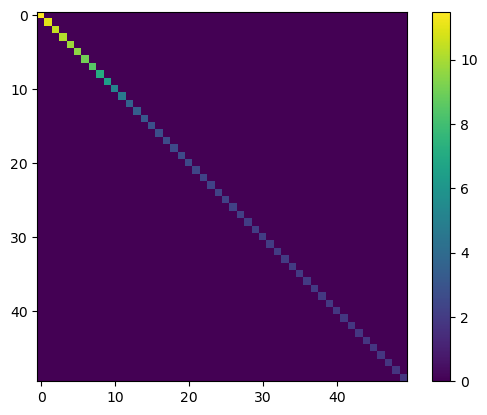

In [ ]:
U,S,V = np.linalg.svd(params, full_matrices=False)
# plt.imshow(U)
plt.imshow(np.diag(S[:50]))
# plt.imshow(V)
plt.colorbar()

## Two-layer stacked RNN

In [54]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvStack(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvStack, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnn = nn.RNN(input_size=64 * 12 * 12, hidden_size=240, 
                          num_layers=2, batch_first=True, dropout=0.5)
        self.LNormRNN = nn.LayerNorm(240)
        self.fcchar = nn.Linear(240, num_classes)
        self.fcpos = nn.Linear(240, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnn(x)[0]
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvStack(num_classes=10, num_pos=2, kernel_size=5)
print(f"RNN model parameter count: {model_param_count(mdl_rnn)}")
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

RNN model parameter count: 2574988
Epoch 1/50 - Train (char, pos): (10.17%, 1044.88 pix^2)  Validation (char, pos): (9.93%, 437.34 pix^2)
Epoch 2/50 - Train (char, pos): (10.33%, 381.28 pix^2)  Validation (char, pos): (10.55%, 333.24 pix^2)
Epoch 3/50 - Train (char, pos): (10.48%, 261.57 pix^2)  Validation (char, pos): (11.30%, 184.40 pix^2)
Epoch 4/50 - Train (char, pos): (10.31%, 189.89 pix^2)  Validation (char, pos): (9.89%, 159.15 pix^2)
Epoch 5/50 - Train (char, pos): (13.64%, 167.69 pix^2)  Validation (char, pos): (17.55%, 156.85 pix^2)
Epoch 6/50 - Train (char, pos): (19.28%, 162.05 pix^2)  Validation (char, pos): (20.49%, 145.13 pix^2)
Epoch 7/50 - Train (char, pos): (21.94%, 151.61 pix^2)  Validation (char, pos): (20.92%, 136.54 pix^2)
Epoch 8/50 - Train (char, pos): (24.22%, 151.23 pix^2)  Validation (char, pos): (23.73%, 138.65 pix^2)
Epoch 9/50 - Train (char, pos): (27.50%, 141.90 pix^2)  Validation (char, pos): (28.30%, 133.79 pix^2)
Epoch 10/50 - Train (char, pos): (31.24

## Split RNN, split classification
RNNs are separated into distinct classification channels

In [61]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvSplitDisc(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvSplitDisc, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnnchar = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.rnnpos = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.LNormRNNPos = nn.LayerNorm(128)
        self.LNormRNNChar = nn.LayerNorm(128)
        self.fcchar = nn.Linear(128, num_classes)
        self.fcpos = nn.Linear(128, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        xchar = self.rnnchar(x)[0]
        xpos = self.rnnpos(x)[0]
        xchar = self.LNormRNNChar(xchar)
        xpos = self.LNormRNNPos(xpos)
        xchar = nn.Dropout(0.5)(nn.ReLU()(xchar))
        xpos = nn.Dropout(0.5)(nn.ReLU()(xpos))
        return xchar, xpos

    def classifier(self, xc, xp):
        return self.fcchar(xc), self.fcpos(xp)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        xc, xp = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(xc, xp)
        return char_out, pos_out

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvSplitDisc(num_classes=10, num_pos=2, kernel_size=5)
print(f"RNN model parameter count: {model_param_count(mdl_rnn)}")
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

RNN model parameter count: 2580652
Epoch 1/50 - Train (char, pos): (10.36%, 1399.52 pix^2)  Validation (char, pos): (10.49%, 614.85 pix^2)
Epoch 2/50 - Train (char, pos): (11.01%, 461.18 pix^2)  Validation (char, pos): (10.44%, 428.46 pix^2)
Epoch 3/50 - Train (char, pos): (12.67%, 381.31 pix^2)  Validation (char, pos): (13.81%, 339.84 pix^2)
Epoch 4/50 - Train (char, pos): (18.04%, 295.52 pix^2)  Validation (char, pos): (16.14%, 271.65 pix^2)
Epoch 5/50 - Train (char, pos): (20.53%, 246.13 pix^2)  Validation (char, pos): (21.47%, 216.93 pix^2)
Epoch 6/50 - Train (char, pos): (25.78%, 206.18 pix^2)  Validation (char, pos): (26.76%, 189.22 pix^2)
Epoch 7/50 - Train (char, pos): (29.89%, 184.58 pix^2)  Validation (char, pos): (29.54%, 177.54 pix^2)
Epoch 8/50 - Train (char, pos): (35.29%, 168.03 pix^2)  Validation (char, pos): (34.12%, 161.81 pix^2)
Epoch 9/50 - Train (char, pos): (41.45%, 154.15 pix^2)  Validation (char, pos): (35.79%, 165.53 pix^2)
Epoch 10/50 - Train (char, pos): (46.

KeyboardInterrupt: 

## Split RNN, shared classification
One for character, the other for position

In [9]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvSplit(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvSplit, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnnchar = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.rnnpos = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(256)
        self.fcchar = nn.Linear(256, num_classes)
        self.fcpos = nn.Linear(256, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        xchar = self.rnnchar(x)[0]
        xpos = self.rnnpos(x)[0]
        x = torch.cat((xchar, xpos), dim=2)
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvSplit(num_classes=10, num_pos=2, kernel_size=5)
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

Epoch 1/50 - Train (char, pos): (10.28%, 1007.72 pix^2)  Validation (char, pos): (9.53%, 408.06 pix^2)
Epoch 2/50 - Train (char, pos): (12.10%, 356.80 pix^2)  Validation (char, pos): (14.09%, 339.01 pix^2)
Epoch 3/50 - Train (char, pos): (18.56%, 299.95 pix^2)  Validation (char, pos): (17.79%, 285.08 pix^2)
Epoch 4/50 - Train (char, pos): (24.43%, 266.72 pix^2)  Validation (char, pos): (25.65%, 258.40 pix^2)
Epoch 5/50 - Train (char, pos): (32.65%, 246.95 pix^2)  Validation (char, pos): (32.47%, 236.49 pix^2)
Epoch 6/50 - Train (char, pos): (41.55%, 226.74 pix^2)  Validation (char, pos): (39.48%, 220.59 pix^2)
Epoch 7/50 - Train (char, pos): (49.09%, 209.48 pix^2)  Validation (char, pos): (42.83%, 212.25 pix^2)
Epoch 8/50 - Train (char, pos): (56.56%, 194.53 pix^2)  Validation (char, pos): (45.95%, 202.17 pix^2)
Epoch 9/50 - Train (char, pos): (62.79%, 186.15 pix^2)  Validation (char, pos): (47.67%, 199.44 pix^2)
Epoch 10/50 - Train (char, pos): (68.38%, 178.92 pix^2)  Validation (char

## Shared layer 1 RNN, split at layer 2

In [11]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConvShareSplit(nn.Module):
    def __init__(self, num_classes, num_pos, kernel_size=3, device='cuda'):
        super(RNNConvShareSplit, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(2, 32, kernel_size=kernel_size, padding='same')
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnnshare = nn.RNN(input_size=64 * 12 * 12, hidden_size=128, 
                          num_layers=1, batch_first=True)
        self.rnnchar = nn.RNN(input_size=128, hidden_size=64, 
                          num_layers=1, batch_first=True)
        self.rnnpos = nn.RNN(input_size=128, hidden_size=64, 
                          num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(128)
        self.fcchar = nn.Linear(128, num_classes)
        self.fcpos = nn.Linear(128, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        x = self.rnnshare(x)[0]
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        xchar = self.rnnchar(x)[0]
        xpos = self.rnnpos(x)[0]
        x = torch.cat((xchar, xpos), dim=2)
        x = self.LNormRNN(x)
        x = nn.Dropout(0.5)(nn.ReLU()(x))
        return x

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)

        batch_size, frame_num, channels, height, width = x.size()

        # resize to process each frame individually
        x = x.view(batch_size * frame_num, channels, height, width)

        # apply CNN encoder
        x = self.encoder(x)
        
        # reshape back to batches of stacks of frames and flatten each image
        x = x.view(batch_size, frame_num, -1)

        # apply RNN
        x = self.middle(x)

        # apply classification heads
        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


train_ds = MC_RNN_Dataset(stims_train, lbls_train)
val_ds = MC_RNN_Dataset(stims_val, lbls_val)
mdl_rnn = RNNConvShareSplit(num_classes=10, num_pos=2, kernel_size=5)
results_rnn = network_train(mdl_rnn, train_ds, val_ds, num_epochs=50, loss_weights=[1.0, 0.001])

Epoch 1/50 - Train (char, pos): (10.13%, 1466.85 pix^2)  Validation (char, pos): (10.29%, 610.03 pix^2)
Epoch 2/50 - Train (char, pos): (10.20%, 464.04 pix^2)  Validation (char, pos): (11.91%, 438.14 pix^2)
Epoch 3/50 - Train (char, pos): (10.14%, 380.08 pix^2)  Validation (char, pos): (9.88%, 327.60 pix^2)
Epoch 4/50 - Train (char, pos): (10.27%, 276.87 pix^2)  Validation (char, pos): (9.66%, 240.29 pix^2)
Epoch 5/50 - Train (char, pos): (10.85%, 220.14 pix^2)  Validation (char, pos): (10.60%, 201.26 pix^2)
Epoch 6/50 - Train (char, pos): (10.73%, 196.96 pix^2)  Validation (char, pos): (11.34%, 179.14 pix^2)
Epoch 7/50 - Train (char, pos): (11.32%, 182.92 pix^2)  Validation (char, pos): (11.23%, 171.28 pix^2)
Epoch 8/50 - Train (char, pos): (15.11%, 189.85 pix^2)  Validation (char, pos): (16.30%, 188.08 pix^2)
Epoch 9/50 - Train (char, pos): (18.86%, 197.10 pix^2)  Validation (char, pos): (15.61%, 203.26 pix^2)
Epoch 10/50 - Train (char, pos): (21.10%, 191.42 pix^2)  Validation (char,